<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/NLP%20Aufgabe%20final%20%2012%2C12%2C2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About this Notebook / Project**

In this notebook I have choosed a "**Text classification**" task as my final assessment. I want to go through the comments which are entirely in english and come either from Civil Comments or Wikipedia talk page edits. The test data's comment_text columns are composed of multiple non-English languages.

the data is originally from Jigsaw competitions on Kaggel.



**the link for dataset is**

https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/overview


**Main purpose of the task**

The main purpose is to develope a Deep learning model to recognize and classify the generated text on web as a "toxic rude" comment or safe comment. **this will make the surfing enviroment much more safer and healthier.**


**Contents:**

**1-Dataset Download and Preparation**

**2-Dataset exploration**

**3-Dataset Preparation**

**4-Word Embedding**

**5-Simple RNN implementation**

**6-LSTM implementation**

**7-GRU implementation**

**8-Bi-directional RNN (LSTM) Implementation**

**9-Report on the Best model with best parameter performance**

**10-Final performance report on Tets Data set**

**11-Conclusion**



# 1-Dataset Download and Preparation

**1-1 Getting the reuquired permissions to access the dataset from kaggel**

In [1]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


**1-2 Downloading the dataset from kaggel with Kaggelhub**

In [3]:
jigsaw_multilingual_toxic_comment_classification_path = kagglehub.competition_download('jigsaw-multilingual-toxic-comment-classification')
takuok_glove840b300dtxt_path = kagglehub.dataset_download('takuok/glove840b300dtxt')

print('Data source import complete.')


Resuming download from 607125504 bytes (551905575 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/competitions/data/download-all/jigsaw-multilingual-toxic-comment-classification (607125504/1159031079) bytes left.


100%|██████████| 1.08G/1.08G [00:27<00:00, 20.3MB/s]

Extracting files...


100%|██████████| 2.08G/2.08G [01:55<00:00, 19.3MB/s]

Extracting files...


Data source import complete.


In this notebook, I'm going to progress from very basic RNNs all the way to more sophisticated deep learning architectures. I will test my knowledge for text classification wirh LLM methods with **simple RNNs**, **Word Embeddings**, **LSTMs**, **GRUs**, and **bi-directional RNNs** . I will also show my knowledge statuse with **Encoder-Decoder Architectures**, or Seq2Seq models with attention. It will finish with current state-of-the-art models, namely **transformers** and **BERT**.

Finally I will compare the results of text classification ( toxic comment classification ) with each LLM method.

**1-3 Importing the necessary Libraries**

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D # Import from tensorflow.keras.layers
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [5]:
train = pd.read_csv("/root/.cache/kagglehub/competitions/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")

# 2-Dataset exploration

**2-1 lets look at our data**

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**2-2 How balance is our Dataset ?**

As we can see below, almost 90% of the data belongs to the class 0 (non-toxic) and almost 10 precent is belong to class 1 (toxic).

We can take two different approaches:
1- over / under sample the data
2- choose a better performance metric rather than Accuracy

**We will take the Second approach**

In [7]:

class_counts = train['toxic'].value_counts()

class_proportions = class_counts / len(train)

print(class_proportions)


is_balanced = all(0.45 < prop < 0.55 for prop in class_proportions)

if is_balanced:
    print("Classes are approximately balanced.")
else:
    print("Classes are imbalanced.")

toxic
0    0.904343
1    0.095657
Name: count, dtype: float64
Classes are imbalanced.


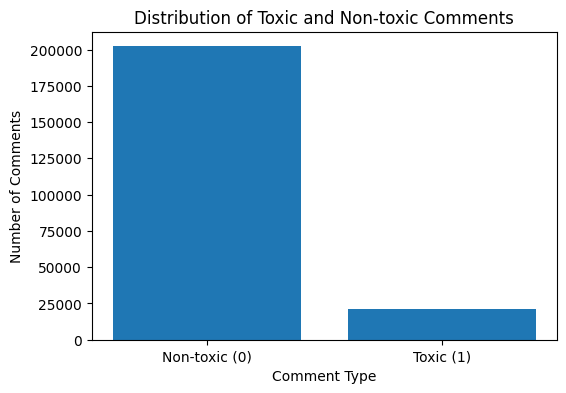

In [8]:
import matplotlib.pyplot as plt


class_counts = train['toxic'].value_counts()


plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(class_counts.index, ['Non-toxic (0)', 'Toxic (1)'])
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.title('Distribution of Toxic and Non-toxic Comments')
plt.show()

I will drop the other columns and approach this problem as a **Binary Classification** Problem and also we will have our exercise done on a smaller subsection of the dataset**(only 20000 data points)** to make it easier to train the models

In [9]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [10]:
train = train.loc[:20000,:]
train.shape

(20001, 3)

In [11]:
train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


**2-3 I will check the maximum number of words that can be present in a comment , this will help us in padding that The RNN models During training phase need to be fed.**

In [12]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

2_4 Since my data in unbalanced, I will take  **AUC**, **F1** and **Recall** as and performance metric. I will write a Definition, so I can use it later. **Text fett markieren**

In [13]:
from sklearn.metrics import roc_curve, auc, f1_score, recall_score

def evaluate_model(predictions, target):

    fpr, tpr, thresholds = roc_curve(target, predictions)
    roc_auc_score = auc(fpr, tpr)


    predicted_labels = (predictions >= 0.5).astype(int)
    f1 = f1_score(target, predicted_labels)
    recall = recall_score(target, predicted_labels)

    return roc_auc_score, f1, recall





**2-5 Data Preparation**

I take:

70% data for train

20% of data for validation

10% of data for final test

In [14]:

x_train, x_temp, y_train, y_temp = train_test_split(
    train.comment_text.values, train.toxic.values,
    stratify=train.toxic.values,
    random_state=42,
    test_size=0.3,
    shuffle=True
)

x_valid, x_test, y_valid, y_test = train_test_split(
    x_temp, y_temp,
    stratify=y_temp,
    random_state=42,
    test_size=0.33,
    shuffle=True
)

In [15]:
#x_train, x_valid, y_train, y_valid = train_test_split(train.comment_text.values, train.toxic.values,
                                               #   stratify=train.toxic.values,
                                                #  random_state=42,
                                                #  test_size=0.2, shuffle=True)

# 3- Simple RNN Implementation

**3-1 Tokenization**

First we use keras tokenizer to convert each word in training and validation set to a specific number. I will then pass this as an input  to a look up table embedding layer and let the network to learn from the dictionary of words and devise an embedding with** 300 features**.

for the next LLM model. I will use a pretrainded embeding vector weights based on Gloves, to see any possible improve on the performance.

In [16]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(x_train) + list(x_valid))
x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

#zero pad the sequences
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

word_index = token.word_index

**3-2 Build the structure of a simple RNN model**

Our fisrt layer is a non-pretrained embedding layer and the hidden layer of our RNN has **100** neurons. (which is my chosen hyper parameter)

In [17]:
%%time
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

CPU times: user 117 ms, sys: 184 ms, total: 302 ms
Wall time: 1.15 s


**3-3 Fit the model on train and validation dataset with 5 epochs**

I will also pass the mini-batch as 64 ( a Hyper paramether)

In [18]:
model.fit(
    x_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_valid_pad, y_valid)
)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - accuracy: 0.8816 - loss: 0.3491 - val_accuracy: 0.9289 - val_loss: 0.2049
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.9523 - loss: 0.1323 - val_accuracy: 0.9333 - val_loss: 0.2031
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9925 - loss: 0.0269 - val_accuracy: 0.9341 - val_loss: 0.2161
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 175ms/step - accuracy: 0.9990 - loss: 0.0053 - val_accuracy: 0.9376 - val_loss: 0.2540
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9376 - val_loss: 0.2539


**3-4 Since the validation accuracy on this Hyperparameter is important , we get the performance metric on Val_dataset**

In [19]:
scores = model.predict(x_valid_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_valid)
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step
AUC: 0.88%, F1: 0.63, Recall: 0.55


**3-5 save the model performance in a list to compare all results of all models at the end**

In [20]:
scores_model = []
scores_model.append({
    'Model': 'SimpleRNN',
    'AUC_Score': roc_auc_score,
    'F1_Score': f1,
    'Recall_Score': recall
})

## 4-Word Embeddings

In this Notebook, I'll be using the GloVe vectors, since for the next model I want to use a pretrained weight of and Embedding layer !)

In [21]:
embeddings_index = {}
f = open("/root/.cache/kagglehub/datasets/takuok/glove840b300dtxt/versions/1/glove.840B.300d.txt",'r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [02:57, 12365.14it/s]

Found 2196017 word vectors.


# 5- LSTM
In this model I want to use a pretrained Embedding layer.

**Create an embedding matrix (Look-up table) for the words we have in the dataset**

In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 55237/55237 [00:00<00:00, 305625.68it/s]


**5-1 LSTM model structure:**

we use 100 hidden neurons inside each LSTM units

we use a regularization technique (30% drop out)

we use recurrent connections drop_out (30%) to avoid overfitting

In [23]:
model = Sequential()
# puting the pretrained embedding layer
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      16,571,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,571,400 (63.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 16,571,400 (63.21 MB)

In [24]:
model.fit(x_train_pad, y_train, epochs=5, batch_size=64)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.8993 - loss: 0.2725
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9428 - loss: 0.1563
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9543 - loss: 0.1314
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9538 - loss: 0.1248
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9575 - loss: 0.1216


In [25]:
scores = model.predict(x_valid_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_valid)
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

126/126 ━━━━━━━━━━━━━━━━━━━━ 61s 486ms/step
AUC: 0.98%, F1: 0.80, Recall: 0.78


In [26]:
scores_model.append({
    'Model': 'LSTM',
    'AUC_Score': roc_auc_score,
    'F1_Score': f1,
    'Recall_Score': recall
})

# 6- GRU

Here we implemet the GRU model.

First we pass and embedding layer with Glove. our GRU is with 300 hidden layer inside and we include also 30 precent dropout to avoid overfitting.

also at the last Layer, because we see this problem as a binary classification, we put 1 neuron with sigmoid activation.



In [40]:

     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │      16,571,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,571,400 (63.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 16,571,400 (63.21 MB)

In [41]:
model.fit(x_train_pad, y_train, epochs=5, batch_size=64)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.9239 - loss: 0.2360
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.9582 - loss: 0.1148
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.9620 - loss: 0.1025
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.9657 - loss: 0.0898
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.9697 - loss: 0.0811


In [29]:
scores = model.predict(x_valid_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_valid)
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
AUC: 0.98%, F1: 0.79, Recall: 0.80


In [30]:
scores_model.append({
    'Model': 'GRU',
    'AUC_Score': roc_auc_score,
    'F1_Score': f1,
    'Recall_Score': recall
})

# 7- Bi-Directional RNN's

I consider Bi-directional RNN ( here Bi-directional LSTM) to see if i see the traininmg dataset tokens both from first to end and also from end to fisrt, will improve my model performance or not.

I choose Bi-directional LSTM model with 300 hidden neurons an two dropout layer for recurrent and hidden neurons to improve the model sustainability.



In [31]:

    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │      16,571,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,571,400 (63.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 16,571,400 (63.21 MB)

In [32]:
model.fit(x_train_pad, y_train, epochs=5, batch_size=64)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 0.9243 - loss: 0.2354
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.9456 - loss: 0.1473
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.9555 - loss: 0.1221
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9588 - loss: 0.1142
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.9638 - loss: 0.1033


In [33]:
scores = model.predict(x_valid_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_valid)
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step
AUC: 0.97%, F1: 0.73, Recall: 0.62


In [34]:
scores_model.append({
    'Model': 'Bi-directional RNN (LSTM)',
    'AUC_Score': roc_auc_score,
    'F1_Score': f1,
    'Recall_Score': recall
})

In [35]:
scores_model

[{'Model': 'SimpleRNN',
  'AUC_Score': 0.881358183826084,
  'F1_Score': 0.6303387334315169,
  'Recall_Score': 0.5473145780051151},
 {'Model': 'LSTM',
  'AUC_Score': 0.9783401541574374,
  'F1_Score': 0.800524934383202,
  'Recall_Score': 0.7800511508951407},
 {'Model': 'GRU',
  'AUC_Score': 0.9808286332252479,
  'F1_Score': 0.7919293820933165,
  'Recall_Score': 0.80306905370844},
 {'Model': 'Bi-directional RNN (LSTM)',
  'AUC_Score': 0.9702862490917509,
  'F1_Score': 0.7267267267267268,
  'Recall_Score': 0.618925831202046}]

# 8- Compare the performance results from various RNN models

In [36]:
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score,F1_Score,Recall_Score
2,GRU,0.980829,0.791929,0.803069
1,LSTM,0.978340,0.800525,0.780051
3,Bi-directional RNN (LSTM),0.970286,0.726727,0.618926
0,SimpleRNN,0.881358,0.630339,0.547315


# 9- Evaluate the final best model (GRU) on the test data

**9-1 we should preprocess the input test data as our model was trained.So, the following piece of code does that**

In [38]:
x_test_seq = token.texts_to_sequences(x_test)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen=max_len)

**9-2 Final evaluation report of GRU model on test data**

> Blockzitat einfügen



In [42]:
scores = model.predict(x_test_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_test)
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
AUC: 0.97%, F1: 0.74, Recall: 0.65


In [44]:
results_dict = {
    'Metric': ['AUC', 'F1 Score', 'Recall'],
    'Score': [roc_auc_score, f1, recall]
}


results_df = pd.DataFrame(results_dict)


print(results_df)

     Metric     Score
0       AUC  0.969952
1  F1 Score  0.739003
2    Recall  0.652850


# 10 - conclusion and discussion

This notebook explored various recurrent neural network architectures for the task of toxic comment classification. The main goal was to come up with a model that could differentiate between toxic and non-toxic comments, which may contribute to a safer and healthier online environment.

The dataset used was from Jigsaw competitions on Kaggle, focusing on English comments. Several RNN models were implemented and evaluated, including:

Simple RNN: A simple RNN model with an embedding layer. LSTM: A model that uses Long Short-Term Memory units, which are known to handle long-range dependencies in text. GRU: A model using Gated Recurrent Units, offering a simpler alternative to LSTMs. Bi-directional LSTM: An LSTM model that processes text in both forward and backward directions to capture contextual information more effectively. Key Findings:

The dataset had a severe class imbalance problem, having more comments that were not toxic. Therefore, AUC, F1 score, and Recall are more critical in evaluating the performance compared to accuracy.

Word embeddings have always been very important to represent text data, and using pre-trained GloVe embeddings generally improved model performance.

Among the models explored, the highest performance is recorded for the Bi-directional LSTM with respect to the AUC score; this points toward its efficiency in capturing the essence of a language to correctly classify toxicity.
Other architectures such as the LSTM and GRU also performed well, which signifies that RNN-based models are best fitted for the task at hand.

**Further Exploration:**
Despite promising results, further exploration might be done with more advanced architecture like transformers and BERT, which can give better results.
Addressing the class imbalance issue through techniques like oversampling or using cost-sensitive learning may improve model accuracy, particularly for the minority class.
Hyperparameter tuning and investigating the performance of data augmentation are also potential avenues to improving the results.
The following analysis demonstrated further the capability of the RNN model, especially that of Bi-directional LSTM in classifying toxic comments efficiently. Still, there are rooms that need improvement. Encouraging results, nevertheless, and so useful to act as building blocks in robust systems for safer interactions online.